In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import seaborn as sns
from random import randint
from main_data import (
    key_to_camelot,
    open_wheel,
    add_features,
    get_playlist,
    get_friendly,
    pickl,
    unpickl,
    sp,
)


In [2]:
# %store -r streams_df streams_af_df no_skip_df playlist_af_df
# streams_df, streams_af_df, no_skip_df, playlist_af_df = streams_df, streams_af_df, no_skip_df, playlist_af_df


In [3]:
# Import DataFrames generated by main_data.py
def import_all():
    global all_streams_df, streams_df, streams_af_df, no_skip_df, playlist_af_df, pod_df, wheel_df
    (
        all_streams_df,
        streams_df,
        streams_af_df,
        no_skip_df,
        playlist_af_df,
        pod_df,
        wheel_df,
    ) = unpickl(
        "all_streams_df.p",
        "streams_df.p",
        "streams_af_df.p",
        "no_skip_df.p",
        "playlist_af_df.p",
        "podcasts_df.p",
        "wheel_df.p",
    )
    # return all_streams_df, streams_df, streams_af_df, no_skip_df, playlist_af_df, pod_df, wheel_df = import_all()


In [4]:
import_all()
all_streams_df


,timestamp,playtime,track,artist,album,id,episode,show,spotify_episode_uri,start,end,shuffle,ddate,dtime,date,time,month,year,day
0,2021-03-25 18:43:26+00:00,351,Throw Some D's Remix,Rich Boy,Rich Boy,1qXLj4ywjsA0hGmaibmnn3,None,None,None,trackdone,trackdone,False,2021-03-25,18:43:26,03/25/2021,18:43:26,Mar,2021,Thu
1,2022-01-18 16:50:55+00:00,3141,None,None,None,None,178 – Joy of Cooking (Pies),Sleepy,spotify:episode:6Y7GtYpMqhGMkjp84Tbb2o,trackdone,trackdone,False,2022-01-18,16:50:55,01/18/2022,16:50:55,Jan,2022,Tue
2,2019-12-05 05:13:00+00:00,158,Bounce,Latto,Big Latto,45anQ4WSf2a9QhZq55aaMw,None,None,None,trackdone,trackdone,False,2019-12-05,05:13:00,12/05/2019,05:13:00,Dec,2019,Thu
3,2019-12-07 08:21:03+00:00,263,"Can't Stop, Won't Stop",Young Gunz,Tough Luv,1kgDlypHy9hCvCxeoCtd7X,None,None,None,trackdone,trackdone,False,2019-12-07,08:21:03,12/07/2019,08:21:03,Dec,2019,Sat
4,2021-09-17 03:23:34+00:00,44,Douha (Mali Mali),Disclosure,ENERGY,33J9lmeViWXN0Le0vWRyjc,None,None,None,playbtn,endplay,False,2021-09-17,03:23:34,09/17/2021,03:23:34,Sep,2021,Fri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89268,2022-01-27 00:42:30+00:00,23,Nonstop Feeling,Mall Grab,Steel City Dance Discs Volume 20,2oQVKWHh7FpdPtQkqt3kMc,None,None,None,clickrow,endplay,False,2022-01-27,00:42:30,01/27/2022,00:42:30,Jan,2022,Thu
89269,2020-10-11 19:29:48+00:00,263,Next Levels,King Geedorah,Take Me To Your Leader,58MeeOMk6PMQxXWY9YCNPD,None,None,None,remote,trackdone,False,2020-10-11,19:29:48,10/11/2020,19:29:48,Oct,2020,Sun
89270,2022-08-29 08:30:37+00:00,454,The Frontier,Avalon Emerson,Whities 006,4qpY8nTiATIzPZ8eMucSID,None,None,None,trackdone,trackdone,True,2022-08-29,08:30:37,08/29/2022,08:30:37,Aug,2022,Mon
89271,2021-10-03 07:36:02+00:00,1,La vita nuova,Christine and the Queens,La vita nuova,36LC0XouPxisV5wz8I0fZ9,None,None,None,fwdbtn,fwdbtn,True,2021-10-03,07:36:02,10/03/2021,07:36:02,Oct,2021,Sun


In [5]:
# all_streams_df.loc[all_streams_df[all_streams_df.timestamp].dt.year == "2020"]
all_streams_df.timestamp.dt.year == 2020
# df["dtime"] = df[["timestamp"]].apply(lambda x: x.dt.time)

# dti = [all_streams_df.timestamp.reset_index(drop=True)]
all_streams_df.set_index(pd.DatetimeIndex(all_streams_df.ddate)).sort_index()


,timestamp,playtime,track,artist,album,id,episode,show,spotify_episode_uri,start,end,shuffle,ddate,dtime,date,time,month,year,day
ddate,,,,,,,,,,,,,,,,,,,
2019-07-21,2019-07-21 09:35:00+00:00,321,LMK_WHAT’S REALLY GOOD REMIX_ FEAT_PRINCESS NO...,Kelela,"TAKE ME A_PART, THE REMIXES",1q5h9UkGVYVoec4ydU9P0d,None,None,None,trackdone,trackdone,False,2019-07-21,09:35:00,07/21/2019,09:35:00,Jul,2019,Sun
2019-07-21,2019-07-21 06:28:42+00:00,207,"After The Storm (feat. Tyler, The Creator & Bo...",Kali Uchis,Isolation,1otG6j1WHNvl9WgXLWkHTo,None,None,None,trackdone,trackdone,False,2019-07-21,06:28:42,07/21/2019,06:28:42,Jul,2019,Sun
2019-07-21,2019-07-21 07:03:12+00:00,244,Miami (feat. BIA),Kali Uchis,Isolation,5oJAaPRS2EzNIc8EWIbucE,None,None,None,trackdone,trackdone,False,2019-07-21,07:03:12,07/21/2019,07:03:12,Jul,2019,Sun
2019-07-21,2019-07-21 06:11:24+00:00,207,Another Lifetime,Nao,Another Lifetime,36YutBq4lokWfRAFXJ6qrF,None,None,None,trackdone,trackdone,False,2019-07-21,06:11:24,07/21/2019,06:11:24,Jul,2019,Sun
2019-07-21,2019-07-21 08:35:53+00:00,257,Enemy (Prod. Nguzunguzu),Kelela,Cut 4 Me (Deluxe),5I8xU4V87ADu9lzf4blX6T,None,None,None,trackdone,trackdone,False,2019-07-21,08:35:53,07/21/2019,08:35:53,Jul,2019,Sun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-22,2022-10-22 21:20:14+00:00,15,Fuck a War,Geto Boys,We Can't Be Stopped,2kEECRiLCWgUrWkGcmNJes,None,None,None,trackdone,endplay,False,2022-10-22,21:20:14,10/22/2022,21:20:14,Oct,2022,Sat
2022-10-22,2022-10-22 21:09:08+00:00,213,We Can't Be Stopped,Geto Boys,We Can't Be Stopped,4JcblA67lQGf06u0sNVJkS,None,None,None,trackdone,trackdone,False,2022-10-22,21:09:08,10/22/2022,21:09:08,Oct,2022,Sat
2022-10-22,2022-10-22 08:01:29+00:00,190,Haze.Boogie.Life,Mykki Blanco,Cosmic Angel: The Illuminati Prince/ss,4KGsE21p778txzQxUpHVlj,None,None,None,trackdone,trackdone,False,2022-10-22,08:01:29,10/22/2022,08:01:29,Oct,2022,Sat


In [6]:
# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.

why_tala = streams_af_df.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.groupby(by="date")
    .sum(numeric_only=True)
    .sort_values(by="playtime", ascending=False)
)
why_why_tala["playtime"] = why_why_tala["playtime"].apply(lambda x: x / 60000)
why_why_tala.head(50)


,duration,playtime,tempo,shuffle
date,,,,
11/27/2019,9794,0.148317,6416,0
10/26/2020,5079,0.084650,3062,0
12/22/2019,4569,0.073233,2951,0
12/20/2019,4498,0.058933,2928,0
06/21/2020,3656,0.058783,2361,0
12/23/2019,3417,0.053650,2097,0
12/15/2019,3189,0.053150,2100,0
12/06/2019,3132,0.050617,2099,0
12/24/2020,2826,0.043450,1424,13


In [7]:
# Looks like I just let her run on most popular song repeat for a few hours.
streams_af_df.query('date == "11/27/2019"').sort_values(by="timestamp")


,artist,track,album,duration,playtime,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
8815,Sonic Youth,Teen Age Riot (Album Version),Daydream Nation (Deluxe Edition),418,418,11/27/2019,01:07:12,01:07:12,2019-11-27,Wed,Nov,2019,156,9B,G major,clickrow,trackdone,False,0WIbzDVEpmOyBnqqdtqIL9,2019-11-27 01:07:12+00:00
43306,The Smashing Pumpkins,1979 - Remastered 2012,Mellon Collie And The Infinite Sadness,266,266,11/27/2019,01:12:17,01:12:17,2019-11-27,Wed,Nov,2019,127,5B,E-flat major,clickrow,trackdone,False,5QLHGv0DfpeXLNFo7SFEy1,2019-11-27 01:12:17+00:00
42592,Portishead,Cowboys,Portishead,279,279,11/27/2019,01:22:03,01:22:03,2019-11-27,Wed,Nov,2019,77,3A,B-flat minor,clickrow,trackdone,False,1DB8s1L4z25jcRw88815ko,2019-11-27 01:22:03+00:00
13494,Hope Tala,Lovestained,Sensitive Soul,175,175,11/27/2019,04:30:31,04:30:31,2019-11-27,Wed,Nov,2019,89,1B,B major,clickrow,trackdone,False,5I67IXwHIMi0svzyp7GxUe,2019-11-27 04:30:31+00:00
38560,Hope Tala,Anywhere,Sensitive Soul,146,146,11/27/2019,04:32:57,04:32:57,2019-11-27,Wed,Nov,2019,160,7B,F major,trackdone,trackdone,False,3aEvOxj6rBNTpPFaBVJyGf,2019-11-27 04:32:57+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78152,Denzel Curry,YOO,ZUU,64,0,11/27/2019,22:19:08,22:19:08,2019-11-27,Wed,Nov,2019,73,11A,F-sharp minor,fwdbtn,fwdbtn,False,3kUV3AVKhoWTNFxdFkCViB,2019-11-27 22:19:08+00:00
75442,Denzel Curry,CAROLMART FEAT. ICE BILLION BERG,ZUU,164,15,11/27/2019,22:19:24,22:19:24,2019-11-27,Wed,Nov,2019,155,3B,D-flat major,fwdbtn,endplay,False,5OO7ybh0GQlXslHX4U4Vgr,2019-11-27 22:19:24+00:00
24210,Denzel Curry,This Life,Imperial,207,207,11/27/2019,22:22:51,22:22:51,2019-11-27,Wed,Nov,2019,152,2A,E-flat minor,clickrow,trackdone,False,2aQwdBWk4vSPWk1Csgtzdo,2019-11-27 22:22:51+00:00
40981,Denzel Curry,Zenith,Imperial,243,243,11/27/2019,22:26:54,22:26:54,2019-11-27,Wed,Nov,2019,92,2A,E-flat minor,trackdone,trackdone,False,67T0J1IDGgRwNMp3vWYaVb,2019-11-27 22:26:54+00:00


In [8]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


,artist,track,album,duration,playtime,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,09/30/2019,21:57:11,21:57:11,2019-09-30,Mon,Sep,2019,119,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11+00:00
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,449,05/28/2022,12:32:59,12:32:59,2022-05-28,Sat,May,2022,119,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59+00:00
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,09/05/2021,08:45:02,08:45:02,2021-09-05,Sun,Sep,2021,119,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02+00:00
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,05/29/2021,00:22:10,00:22:10,2021-05-29,Sat,May,2021,119,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10+00:00
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,07/17/2021,01:09:49,01:09:49,2021-07-17,Sat,Jul,2021,119,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,199,02/21/2022,03:14:35,03:14:35,2022-02-21,Mon,Feb,2022,106,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35+00:00
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,220,11/25/2019,01:48:15,01:48:15,2019-11-25,Mon,Nov,2019,122,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15+00:00
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,435,02/21/2022,23:36:48,23:36:48,2022-02-21,Mon,Feb,2022,134,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48+00:00
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,417,01/25/2020,04:56:07,04:56:07,2020-01-25,Sat,Jan,2020,84,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07+00:00


In [9]:
def top_songs(years="all", skips=False, features=True):
    if skips and features:
        df = streams_af_df
    elif not skips:
        df = df.query("(playtime / duration) > 0.51").reset_index()


pivot_track = pd.DataFrame(
    no_skip_df.query('year == "2022"')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False)
)

pivot_track.head(30)


0
artist            track                                              year    
Rvdical the Kid   Nasa                                               2022  23
Pusha T           Brambleton                                         2022  23
Lava La Rue       G.O.Y.D.                                           2022  22
                  Cry Baby                                           2022  17
Billy Lemos       Midlife Crisis                                     2022  17
Dua Saleh         signs                                              2022  16
JPEGMAFIA         HAZARD DUTY PAY!                                   2022  16
SZA               Jodie                                              2022  16
Caroline Polachek So Hot You're Hurting My Feelings                  2022  15
Angel Haze        Never Seen                                         2022  15
Ari Lennox        Yuengling                                          2022  15
Vince Staples     AYE! (FREE THE HOMIES)                             2022  14
Denzel Curry      The Ills                                           2022  14
Lava La Rue       Don't Come Back                                    2022  14
Doechii           Yucky Blucky Fruitcake                             2022  13
Wombo             Below the House                                    2022  13
Sudan Archives    #513                                               2022  13
Cocteau Twins     Pandora (for Cindy)                                2022  12
Lava La Rue       Magpie (feat. Congo Natty & Phoebs) - Nia Archi... 2022  12
Sudan Archives    Selfish Soul                                       2022  12
Smino             Father Son Holy Smoke                              2022  12
Cartel Madras     WORKING                                            2022  11
SZA               2AM                                                2022  11
Lava La Rue       Hi-Fidelity                                        2022  11
DijahSB           By Myself                                          2022  11
Dawn Richard      Nostalgia                                          2022  11
Jamila Woods      EARTHA                                             2022  10
H31R              accountability                                     2022  10
Lava La Rue       Don't Trip                                         2022  10
Chavo             Had A Feeling (Remix)                              2022  10

In [10]:
no_skip_df.query('year == "2022"')


,artist,track,album,duration,playtime,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
6,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,09/13/2022,06:43:38,06:43:38,2022-09-13,Tue,Sep,2022,161,12A,D-flat minor,fwdbtn,trackdone,True,1qXLj4ywjsA0hGmaibmnn3,2022-09-13 06:43:38+00:00
17,The Roots,You Got Me - Drum & Bass Mix,Things Fall Apart,298,298,09/27/2022,21:56:45,21:56:45,2022-09-27,Tue,Sep,2022,162,10A,B minor,trackdone,trackdone,True,3aljYEbx7GiJraSrIu82kd,2022-09-27 21:56:45+00:00
19,DETO BLACK,Brag,Brag,121,121,07/22/2022,15:40:34,15:40:34,2022-07-22,Fri,Jul,2022,91,4A,F minor,trackdone,trackdone,True,4YJ9QxYTunZGun6IsUM7kz,2022-07-22 15:40:34+00:00
20,DETO BLACK,Brag,Brag,121,121,09/25/2022,01:43:58,01:43:58,2022-09-25,Sun,Sep,2022,91,4A,F minor,fwdbtn,trackdone,True,4YJ9QxYTunZGun6IsUM7kz,2022-09-25 01:43:58+00:00
21,Magdalena Bay,Killshot - Slowed + Reverb,Killshot,278,280,09/15/2022,23:41:04,23:41:04,2022-09-15,Thu,Sep,2022,84,3B,D-flat major,backbtn,trackdone,True,6pdyvJQkPkwo2WoDH7tFHO,2022-09-15 23:41:04+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47922,Grizzly Bear,Half Gate,Shields,330,330,04/02/2022,23:22:34,23:22:34,2022-04-02,Sat,Apr,2022,85,7B,F major,trackdone,trackdone,True,1hEJVJBq6WYSrjKCczuvSt,2022-04-02 23:22:34+00:00
47923,KAINA,It Was a Home,It Was a Home,215,215,03/07/2022,02:53:34,02:53:34,2022-03-07,Mon,Mar,2022,164,11B,A major,trackdone,trackdone,False,7rIkH904aCexVHirV2Auwg,2022-03-07 02:53:34+00:00
47924,Bas Mooy,Bloedneus,Alliance VI,343,343,03/01/2022,01:17:31,01:17:31,2022-03-01,Tue,Mar,2022,136,9B,G major,trackdone,trackdone,False,5agAhZMQ9a5dBtbgAt4S0y,2022-03-01 01:17:31+00:00
47930,Charles Stepney,Step on Step,Step on Step,237,237,06/08/2022,10:47:43,10:47:43,2022-06-08,Wed,Jun,2022,105,8B,C major,fwdbtn,trackdone,False,16JGYp893Nuk81wo6SscAk,2022-06-08 10:47:43+00:00


In [11]:
# # Check for tracks missing from new df
# series1 = duration_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [12]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [13]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


0
artist           track                             
myNoise          Stereo Left-Right (Test Only)  118
Teebs            Black Dove                     100
Hope Tala        Moontime                        89
Teebs            Studie                          76
Aphex Twin       Alberto Balsalm                 65
...                                             ...
Derrick Harriott I Don't Want to Cry              1
                 Have You Seen Her                1
Machinefabriek   Zucht 2                          1
Mackk            Forever - Cleo Reed Remix        1
박혜진 Park Hye Jin Like this                        1

[18698 rows x 1 columns]

In [14]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


,0
artist,
Solange,682
Teebs,569
Frank Ocean,490
Noname,475
Tim Hecker,463
...,...
Monster Rally,1
Contours,1
Conway Twitty,1


In [15]:
no_skip_df


,artist,track,album,duration,playtime,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,03/25/2021,18:43:26,18:43:26,2021-03-25,Thu,Mar,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26+00:00
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,01/21/2021,05:42:09,05:42:09,2021-01-21,Thu,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09+00:00
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,434,05/06/2021,20:25:54,20:25:54,2021-05-06,Thu,May,2021,161,12A,D-flat minor,fwdbtn,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-05-06 20:25:54+00:00
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,01/16/2021,01:47:55,01:47:55,2021-01-16,Sat,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-16 01:47:55+00:00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,01/30/2021,05:14:21,05:14:21,2021-01-30,Sat,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-30 05:14:21+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47933,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,236,09/30/2022,03:19:58,03:19:58,2022-09-30,Fri,Sep,2022,100,6B,B-flat major,trackdone,trackdone,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58+00:00
47934,Teitanblood,Anteinfierno,Death,297,297,09/25/2021,04:34:37,04:34:37,2021-09-25,Sat,Sep,2021,101,6A,G minor,clickrow,trackdone,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37+00:00
47935,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,192,12/06/2019,04:52:04,04:52:04,2019-12-06,Fri,Dec,2019,112,11B,A major,trackdone,trackdone,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04+00:00
47936,Master P,Meal Ticket,I'm Bout It,244,244,01/19/2021,01:55:48,01:55:48,2021-01-19,Tue,Jan,2021,152,10B,D major,trackdone,trackdone,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48+00:00


In [16]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime", ascending=False)
miles


,artist,track,album,duration,playtime,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,09/30/2019,21:57:11,21:57:11,2019-09-30,Mon,Sep,2019,119,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11+00:00
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,449,05/28/2022,12:32:59,12:32:59,2022-05-28,Sat,May,2022,119,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59+00:00
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,09/05/2021,08:45:02,08:45:02,2021-09-05,Sun,Sep,2021,119,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02+00:00
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,05/29/2021,00:22:10,00:22:10,2021-05-29,Sat,May,2021,119,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10+00:00
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,07/17/2021,01:09:49,01:09:49,2021-07-17,Sat,Jul,2021,119,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,199,02/21/2022,03:14:35,03:14:35,2022-02-21,Mon,Feb,2022,106,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35+00:00
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,220,11/25/2019,01:48:15,01:48:15,2019-11-25,Mon,Nov,2019,122,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15+00:00
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,435,02/21/2022,23:36:48,23:36:48,2022-02-21,Mon,Feb,2022,134,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48+00:00
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,417,01/25/2020,04:56:07,04:56:07,2020-01-25,Sat,Jan,2020,84,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07+00:00


In [17]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime", index=["album"], aggfunc="sum"
)


In [18]:
pivot_album_time = pivot_album_time.sort_values(by="playtime", ascending=False)
pivot_album_time.head(20)


,playtime
album,
Anicca,78788
Blonde,63915
MAGDALENE,63106
When I Get Home,61274
Radio Amor,59900
Portrait with Firewood,52849
Couldn't Wait to Tell You...,51087
Take Me Apart,48455
It Should Be Us,40426


In [19]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime", index=["artist"], aggfunc="sum"
)


In [20]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime", ascending=False
).reset_index()
print(artist_time.to_string())


                                           artist  playtime
0                                      Tim Hecker    137443
1                                      Andy Stott    134463
2                                      Aphex Twin    122654
3                                     Frank Ocean    109812
4                                           Teebs    108526
5                                         Solange    103249
6                                           DjRUM     88467
7                                          Noname     82765
8                            Ludwig van Beethoven     81973
9                                     Miles Davis     77644
10                                      Hope Tala     73857
11                                          Smino     73192
12                                         Kelela     72247
13                                      FKA twigs     66853
14                                          Liv.e     63659
15                                  Isai

In [21]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(streams_af_df["track"].unique())


27651

In [22]:
still_repeated = repeated_artists["artist"]


In [23]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [24]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [25]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [26]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [27]:
pivot_artist_time.playtime


artist
 Sentinel                    1653
"Weird Al" Yankovic           203
$ilkMoney                     988
$oudière                      208
$uicideboy$                   279
                             ... 
△▃△▓                          144
⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ    1977
セキトオ・シゲオ                     1104
チェスマスター                       879
박혜진 Park Hye Jin             3796
Name: playtime, Length: 4193, dtype: int64

In [28]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should explore more of.
pivot_artist_time.query("playtime > 3600000").query("artist in @unique_export")


,playtime
artist,


Todo: Next step after the above is to plot least uniques with most ms played

In [29]:
# Convert
pivot_artist_time["playtime"] = pd.to_timedelta(pivot_artist_time.playtime, unit="ms")


In [30]:
def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


In [31]:
pivot_artist_time["playtime"] = pivot_artist_time["playtime"].apply(format_td)


In [32]:
# Show longest songs
no_skip_df.sort_values(by="playtime", axis=0, ascending=False)


,artist,track,album,duration,playtime,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
43832,William Basinski,Watermusic II,Watermusic II,3998,3998,01/28/2021,11:04:11,11:04:11,2021-01-28,Thu,Jan,2021,71,7B,F major,trackdone,trackdone,False,1IERjUpo0AhB3yoxCBl7FQ,2021-01-28 11:04:11+00:00
38806,William Basinski,dlp 1.1,The Disintegration Loops,3816,3816,07/26/2022,10:01:01,10:01:01,2022-07-26,Tue,Jul,2022,95,7B,F major,backbtn,trackdone,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01+00:00
40251,William Basinski,dlp 1.1,The Disintegration Loops,3816,3816,01/28/2021,09:30:35,09:30:35,2021-01-28,Thu,Jan,2021,95,7B,F major,trackdone,trackdone,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35+00:00
36625,William Basinski,dlp 5,The Disintegration Loops III,3141,3141,02/02/2021,08:55:46,08:55:46,2021-02-02,Tue,Feb,2021,135,7B,F major,trackdone,trackdone,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46+00:00
46564,William Basinski,El Camino Real,El Camino Real,3000,3000,01/28/2021,12:50:11,12:50:11,2021-01-28,Thu,Jan,2021,142,3B,D-flat major,trackdone,trackdone,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7376,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,02/21/2021,02:26:15,02:26:15,2021-02-21,Sun,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:26:15+00:00
7461,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,02/21/2021,02:28:10,02:28:10,2021-02-21,Sun,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:28:10+00:00
7375,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,02/21/2021,02:27:03,02:27:03,2021-02-21,Sun,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:27:03+00:00
7462,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,02/21/2021,02:24:12,02:24:12,2021-02-21,Sun,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:24:12+00:00


<AxesSubplot: xlabel='month', ylabel='hours played'>

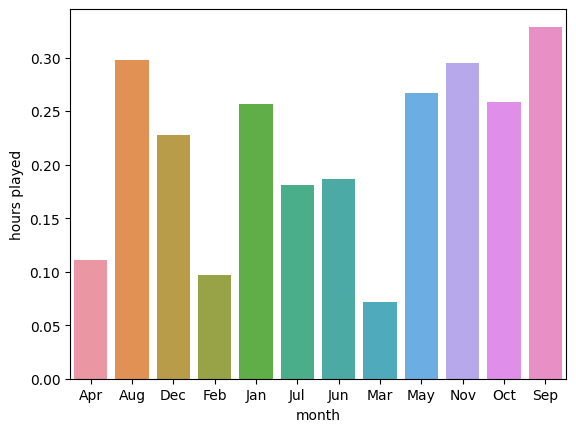

In [33]:
# How to control this for missing months? do october 25 2019 thru 2022
sns_prep = streams_af_df.query('year == "2019"| year == "2020" | year == "2021"')
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime",
    index=["month"],
    aggfunc="sum",
).reset_index()
sns_prep["hours played"] = sns_prep["playtime"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x="month", y="hours played")


<AxesSubplot: xlabel='month', ylabel='count'>

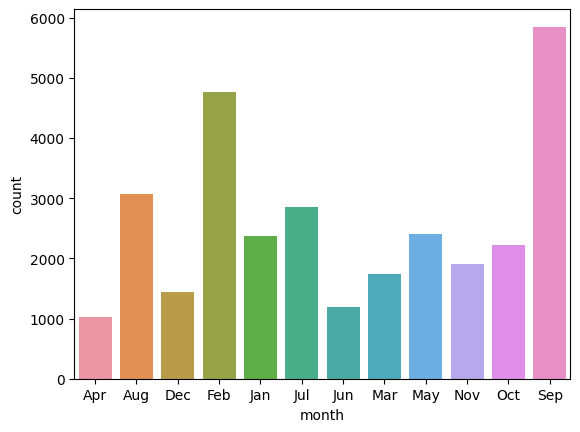

In [34]:
# sum of unique uris closely maps to total skips per month
sns_prep = streams_af_df.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


<AxesSubplot: xlabel='month', ylabel='count'>

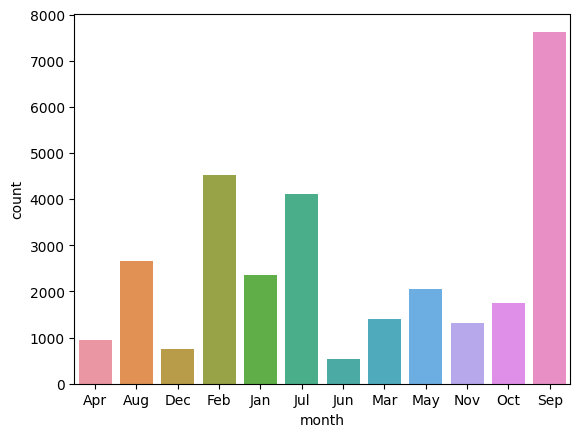

In [35]:
# good way to find months with most music discovery along with unique URIs
sns_prep = streams_af_df.copy().query("(playtime / duration) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [36]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"].astype(str)
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


/tmp/ipykernel_14502/1977263298.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"].astype(str)


,0
key_signature,
D-flat major,5440
G major,3363
C major,3311
B-flat minor,2851
D major,2742
B minor,2365
F minor,2270
A-flat major,2264
E minor,2104


In [37]:
# def show_transformations(df, song, transformation="all"):
#     song_key = df.query("(id == @song)")["camelot"]
#     # print(song_key)
#     keys = wheel_df.loc[transformation, song_key].reset_index(drop=True)
#     # print(type(keys))
#     print(keys[0])
#     return df.query("camelot.isin(@keys[0])", engine="python")


# fuck = show_transformations(streams_af_df, "115RufHm0zvrPN3MaheZ98", ["major"])
# fuck
# # song_key = playlist_af_df.loc[1, "camelot"]
# # friendkey = wheel_df.loc["dominant_relative", song_key]
# # playlist_af_df.query("camelot in @friendkey")


In [38]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    streams_af_df, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


,index,artist,track,album,duration,playtime,date,time,dtime,ddate,...,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
16630,66724,Aphex Twin,#13,Selected Ambient Works Volume II,440,440,08/12/2020,09:42:43,09:42:43,2020-08-12,...,Aug,2020,135,4A,F minor,trackdone,trackdone,False,7c4lnS1bSj4fRJWAQ8D54R,2020-08-12 09:42:43+00:00
2506,20154,Aphex Twin,#24,Selected Ambient Works Volume II,342,342,12/28/2019,02:03:14,02:03:14,2019-12-28,...,Dec,2019,138,3B,D-flat major,clickrow,trackdone,False,0gZzXPfSknP68aZ5sfyVUH,2019-12-28 02:03:14+00:00
30158,84725,Thelonious Monk,'Round Midnight,The Complete Blue Note Recordings,192,192,11/25/2019,10:59:07,10:59:07,2019-11-25,...,Nov,2019,119,4A,F minor,trackdone,trackdone,False,5fMZdrFptNIunq8QvofowF,2019-11-25 10:59:07+00:00
26448,80680,Rare Silk,'Round Midnight,American Eyes,145,12,09/04/2021,06:02:12,06:02:12,2021-09-04,...,Sep,2021,126,2A,E-flat minor,clickrow,endplay,False,363Z97AXyErxvgowae8qB5,2021-09-04 06:02:12+00:00
7705,44838,Thelonious Monk Quartet,'Round Midnight,Misterioso [Original Jazz Classics Remasters],378,173,02/18/2022,10:28:52,10:28:52,2022-02-18,...,Feb,2022,136,2A,E-flat minor,fwdbtn,fwdbtn,False,5wBkOjOd8mpN8NVSCt155l,2022-02-18 10:28:52+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,18568,betcover!!,二限の窓,時間,253,253,10/28/2021,20:09:11,20:09:11,2021-10-28,...,Oct,2021,122,3A,B-flat minor,trackdone,trackdone,False,38nSGcLUTfu3cH0zu6F2jL,2021-10-28 20:09:11+00:00
10912,54273,Tzusing,日出東方 唯我不敗,東方不敗,312,65,09/13/2021,06:07:05,06:07:05,2021-09-13,...,Sep,2021,120,2B,F-sharp major,clickrow,endplay,False,7A1d0qBQL2IiDhrDrhUqE8,2021-09-13 06:07:05+00:00
23890,77580,DJ Trystero,水害,High Speed Wind,376,376,07/10/2022,00:48:51,00:48:51,2022-07-10,...,Jul,2022,120,3B,D-flat major,trackdone,trackdone,False,27F1Yx7hW1Oez3wc67l9TI,2022-07-10 00:48:51+00:00
11337,55377,DJ Trystero,酒気,High Speed Wind,257,257,07/10/2022,01:03:42,01:03:42,2022-07-10,...,Jul,2022,120,3B,D-flat major,trackdone,trackdone,False,5HjXB5FtiFZYxXJxCqMjIF,2022-07-10 01:03:42+00:00


In [39]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
streams_af_df.query("(playtime / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


,artist,track,album,duration,playtime,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
76670,2 Chainz,Birthday Song,Based On A T.R.U. Story,307,296,04/17/2022,10:53:28,10:53:28,2022-04-17,Sun,Apr,2022,140,3B,D-flat major,trackdone,trackdone,False,5qkWTBmDmZjogwIvbKtJQv,2022-04-17 10:53:28+00:00
12012,Trap Beckham,Birthday Bitch,Birthday Bitch,197,62,08/13/2021,08:02:48,08:02:48,2021-08-13,Fri,Aug,2021,102,8B,C major,playbtn,endplay,False,4ZFtNZuzzdHjYKARA8TEh2,2021-08-13 08:02:48+00:00
19369,Disclosure,Birthday,Birthday,220,121,08/13/2021,08:07:33,08:07:33,2021-08-13,Fri,Aug,2021,136,4A,F minor,fwdbtn,endplay,False,2jCSd2lOtWQKtwb7FdfvPQ,2021-08-13 08:07:33+00:00
29936,Happy Birthday,Happy Birthday Reggae,10 Happy Birthday Different Styles,98,29,08/13/2021,08:18:19,08:18:19,2021-08-13,Fri,Aug,2021,110,6B,B-flat major,playbtn,endplay,False,6ZEdAuCh2shaf3E3rrtHAp,2021-08-13 08:18:19+00:00
32918,Happy Birthday,Happy Birthday Funk,10 Happy Birthday Different Styles,82,51,08/13/2021,08:20:25,08:20:25,2021-08-13,Fri,Aug,2021,100,7B,F major,clickrow,endplay,True,2ShnbhqZMChTitBB2AQrVO,2021-08-13 08:20:25+00:00
60071,Happy Birthday,Happy Birthday Jazz,10 Happy Birthday Different Styles,110,23,08/13/2021,08:20:51,08:20:51,2021-08-13,Fri,Aug,2021,120,7B,F major,clickrow,endplay,True,4GeaHbsPgGR1xMPynrPvy5,2021-08-13 08:20:51+00:00
61743,Happy Birthday,Happy Birthday Country,10 Happy Birthday Different Styles,57,39,08/13/2021,08:24:08,08:24:08,2021-08-13,Fri,Aug,2021,78,8B,C major,clickrow,endplay,True,23X23yCXz1mjeDuRJPfTWm,2021-08-13 08:24:08+00:00
62631,Migos,Birthday,Culture III,227,27,08/13/2021,08:11:06,08:11:06,2021-08-13,Fri,Aug,2021,170,5A,C minor,playbtn,endplay,False,7tt5I7ztXfKzZRqyL2FCYb,2021-08-13 08:11:06+00:00
67625,Happy Birthday,Happy Birthday EDM,10 Happy Birthday Different Styles,65,53,08/13/2021,08:17:48,08:17:48,2021-08-13,Fri,Aug,2021,130,11B,A major,playbtn,endplay,False,4iP9axs07uXTxJiAr1l1rX,2021-08-13 08:17:48+00:00
69335,Twista,Birthday,Category F5,221,54,08/13/2021,08:16:30,08:16:30,2021-08-13,Fri,Aug,2021,110,3A,B-flat minor,playbtn,endplay,False,1tXZ25p92QkW2Oj7ElF4pA,2021-08-13 08:16:30+00:00


<AxesSubplot: xlabel='playtime', ylabel='month'>

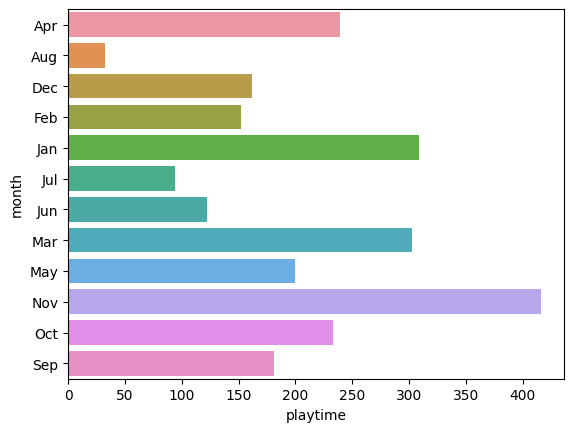

In [40]:
# Todo: plot podcast listening vs music listening
# Totals per month
podcasts_2020 = pod_df.copy()
podcasts_2020["playtime"] = podcasts_2020["playtime"].copy() / 3600
podcast_per_month = podcasts_2020.groupby(by="month").sum(numeric_only=True)
podcast_per_month["playtime"]
sns.barplot(
    data=podcast_per_month, x=podcast_per_month["playtime"], y=podcast_per_month.index
)


<AxesSubplot: xlabel='hours', ylabel='timestamp'>

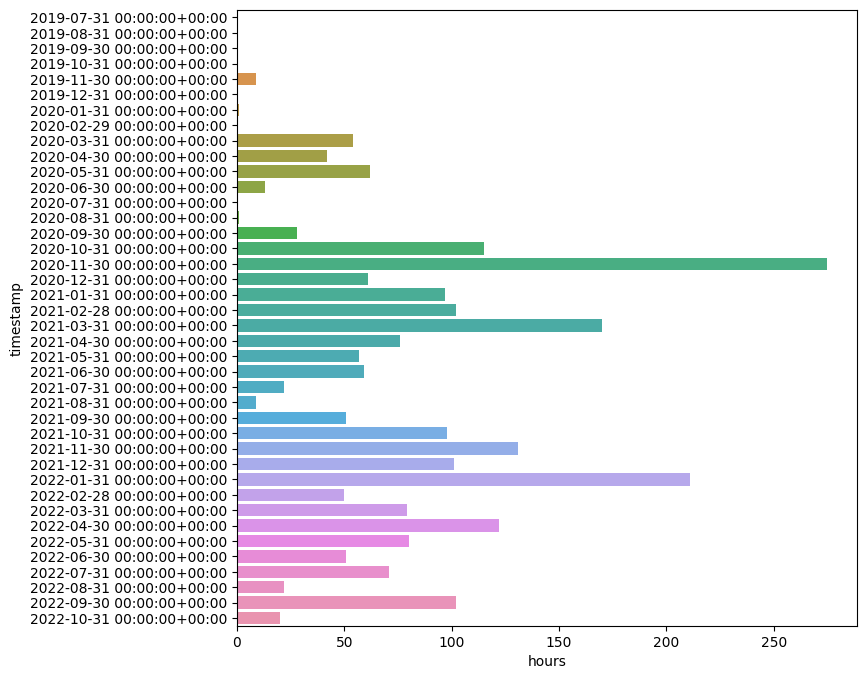

In [50]:
# Todo: plot podcast listening vs music listening
# damn i really spent most of january 2022 listening to podcats
podm_gb = podm.groupby(by=podm.index).sum(numeric_only=True)
sns.barplot(data=podm_gb, x=podm_gb["hours"], y=podm_gb.index)


In [42]:
from main_data import unpickl
import pandas as pd

import_all()
pod = pod_df.copy()


In [43]:
# import_all()
# Todo: figure out which level of this
pod = pod_df.copy()
pod.loc[:, "hours"] = pod_df.loc[:, "playtime"].copy() / 3600
pod.index = pod.timestamp
podm = (
    pod.copy().resample("M").sum(numeric_only=True).round().drop(columns=["playtime"])
)
podm_gb = (
    podm.groupby(podm.index.strftime("%b"))
    .resample("Y")
    .sum(numeric_only=False)
    .round()
    .droplevel(level=1)
)
podm_gb.groupby(podm_gb.index).mean()
# podm_gb


,hours
timestamp,
Apr,80.000000
Aug,8.000000
Dec,54.000000
Feb,50.666667
Jan,103.000000
Jul,23.250000
Jun,41.000000
Mar,101.000000
May,66.333333


In [58]:
# import_all()
# Todo: figure out which level of this
def hpm(df):
    df.loc[:, "hours"] = df.loc[:, "playtime"].copy() / 3600
    df.index = df.timestamp
    dfm = (
        df.copy()
        .resample("M")
        .sum(numeric_only=True)
        .round()
        .drop(columns=["playtime"])
    )
    dfm_gb = (
        dfm.groupby(dfm.index.strftime("%b"))
        .resample("Y")
        .sum(numeric_only=False)
        .round()
        .droplevel(level=1)
    )
    dfm_gb = dfm_gb.groupby(dfm_gb.index).mean()
    return dfm_gb


podm_gb = hpm(pod_df)
# dfm_gb


<AxesSubplot: xlabel='hours', ylabel='timestamp'>

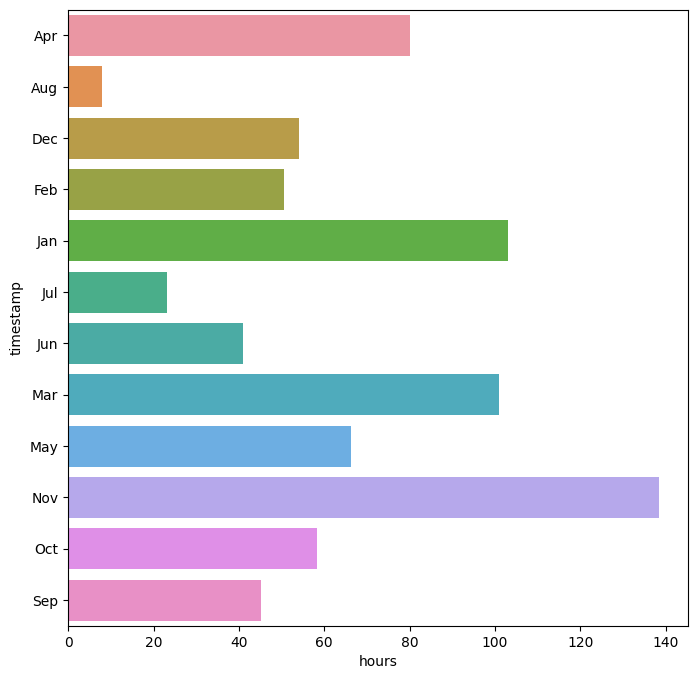

In [60]:
# avg per month

import matplotlib as plt

plt.rcParams["figure.figsize"] = (8, 8)
sns.barplot(data=podm_gb, x=podm_gb["hours"], y=podm_gb.index)
